In [1]:
import imblearn
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree

In [2]:
df = pd.read_csv("contributors2.csv")
selected_columns = ['name_with_owner','is_core', 'repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio']

# Subset the DataFrame based on the selected columns
c3 = df[selected_columns].copy()
#get projects not in cluster
c3_cols = ['umijs/umi', 'netbox-community/netbox', 'grafana/loki', 'awsdocs/aws-doc-sdk-examples', 'vueuse/vueuse',
     'yuzu-emu/yuzu', 'TanStack/query', 'lvgl/lvgl', 'arendst/Tasmota', 'Aircoookie/WLED']
#combine into one list
c3 = c3[c3['name_with_owner'].isin(c3_cols)]
c3 = c3.drop(columns = 'name_with_owner')

In [3]:
c3

,is_core,repos,gists,followers,following,months_experience,has_bio
5,0,151,6,235,36,125.65,1
8,0,55,0,21,3,130.54,0
10,0,136,3,9,19,70.95,1
11,0,548,19,1707,5,108.31,0
12,0,160,8,331,16,122.33,0
...,...,...,...,...,...,...,...
4169,0,41,1,12,36,89.93,1
4170,0,52,0,0,0,15.04,0
4628,0,166,6,24,69,122.94,1
6582,0,38,1,5,7,139.38,0


In [4]:
X = c3.drop(columns = 'is_core')
y = c3['is_core']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [5]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [6]:
train_df

,repos,gists,followers,following,months_experience,has_bio,is_core
3336,28,0,1,0,51.04,0,0
3913,29,3,39,17,154.54,1,0
1267,51,0,276,0,144.57,0,0
2657,20,0,4,8,92.56,0,0
2147,56,31,59,23,85.66,1,0
...,...,...,...,...,...,...,...
937,1,0,0,0,21.36,0,0
3646,118,32,62,1,168.33,1,0
1928,8,0,13,6,156.57,1,0
2960,185,100,63,58,155.64,0,0


In [7]:
print(train_df['is_core'].value_counts())
print(test_df['is_core'].value_counts())

0    2846
1      71
Name: is_core, dtype: int64
0    718
1     12
Name: is_core, dtype: int64


In [8]:
adasyn = imblearn.over_sampling.ADASYN(random_state = 0)
x_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)
c3_train = pd.DataFrame(data=x_resampled_adasyn, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio'])  # Replace column names as needed
c3_train['is_core'] = y_resampled_adasyn  # Assuming 'target' is the name of your target column
c3_train['has_bio'] = c3_train['has_bio'].apply(lambda x: 1 if x >= 0.5 else 0)
c3_train

,repos,gists,followers,following,months_experience,has_bio,is_core
0,28,0,1,0,51.040000,0,0
1,29,3,39,17,154.540000,1,0
2,51,0,276,0,144.570000,0,0
3,20,0,4,8,92.560000,0,0
4,56,31,59,23,85.660000,1,0
...,...,...,...,...,...,...,...
5668,37,2,451,27,67.126912,1,1
5669,38,2,458,39,76.072258,1,1
5670,126,0,294,23,90.733046,0,1
5671,20,52,474,26,118.308642,1,1


In [9]:
c3_train['follower_ratio'] = np.where(c3_train['following'] == 0, c3_train['followers'], c3_train['followers'] / c3_train['following'])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
c3_train

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
0,28,0,1,0,51.040,0,0,1.000
1,29,3,39,17,154.540,1,0,2.294
2,51,0,276,0,144.570,0,0,276.000
3,20,0,4,8,92.560,0,0,0.500
4,56,31,59,23,85.660,1,0,2.565
...,...,...,...,...,...,...,...,...
5668,37,2,451,27,67.127,1,1,16.704
5669,38,2,458,39,76.072,1,1,11.744
5670,126,0,294,23,90.733,0,1,12.783
5671,20,52,474,26,118.309,1,1,18.231


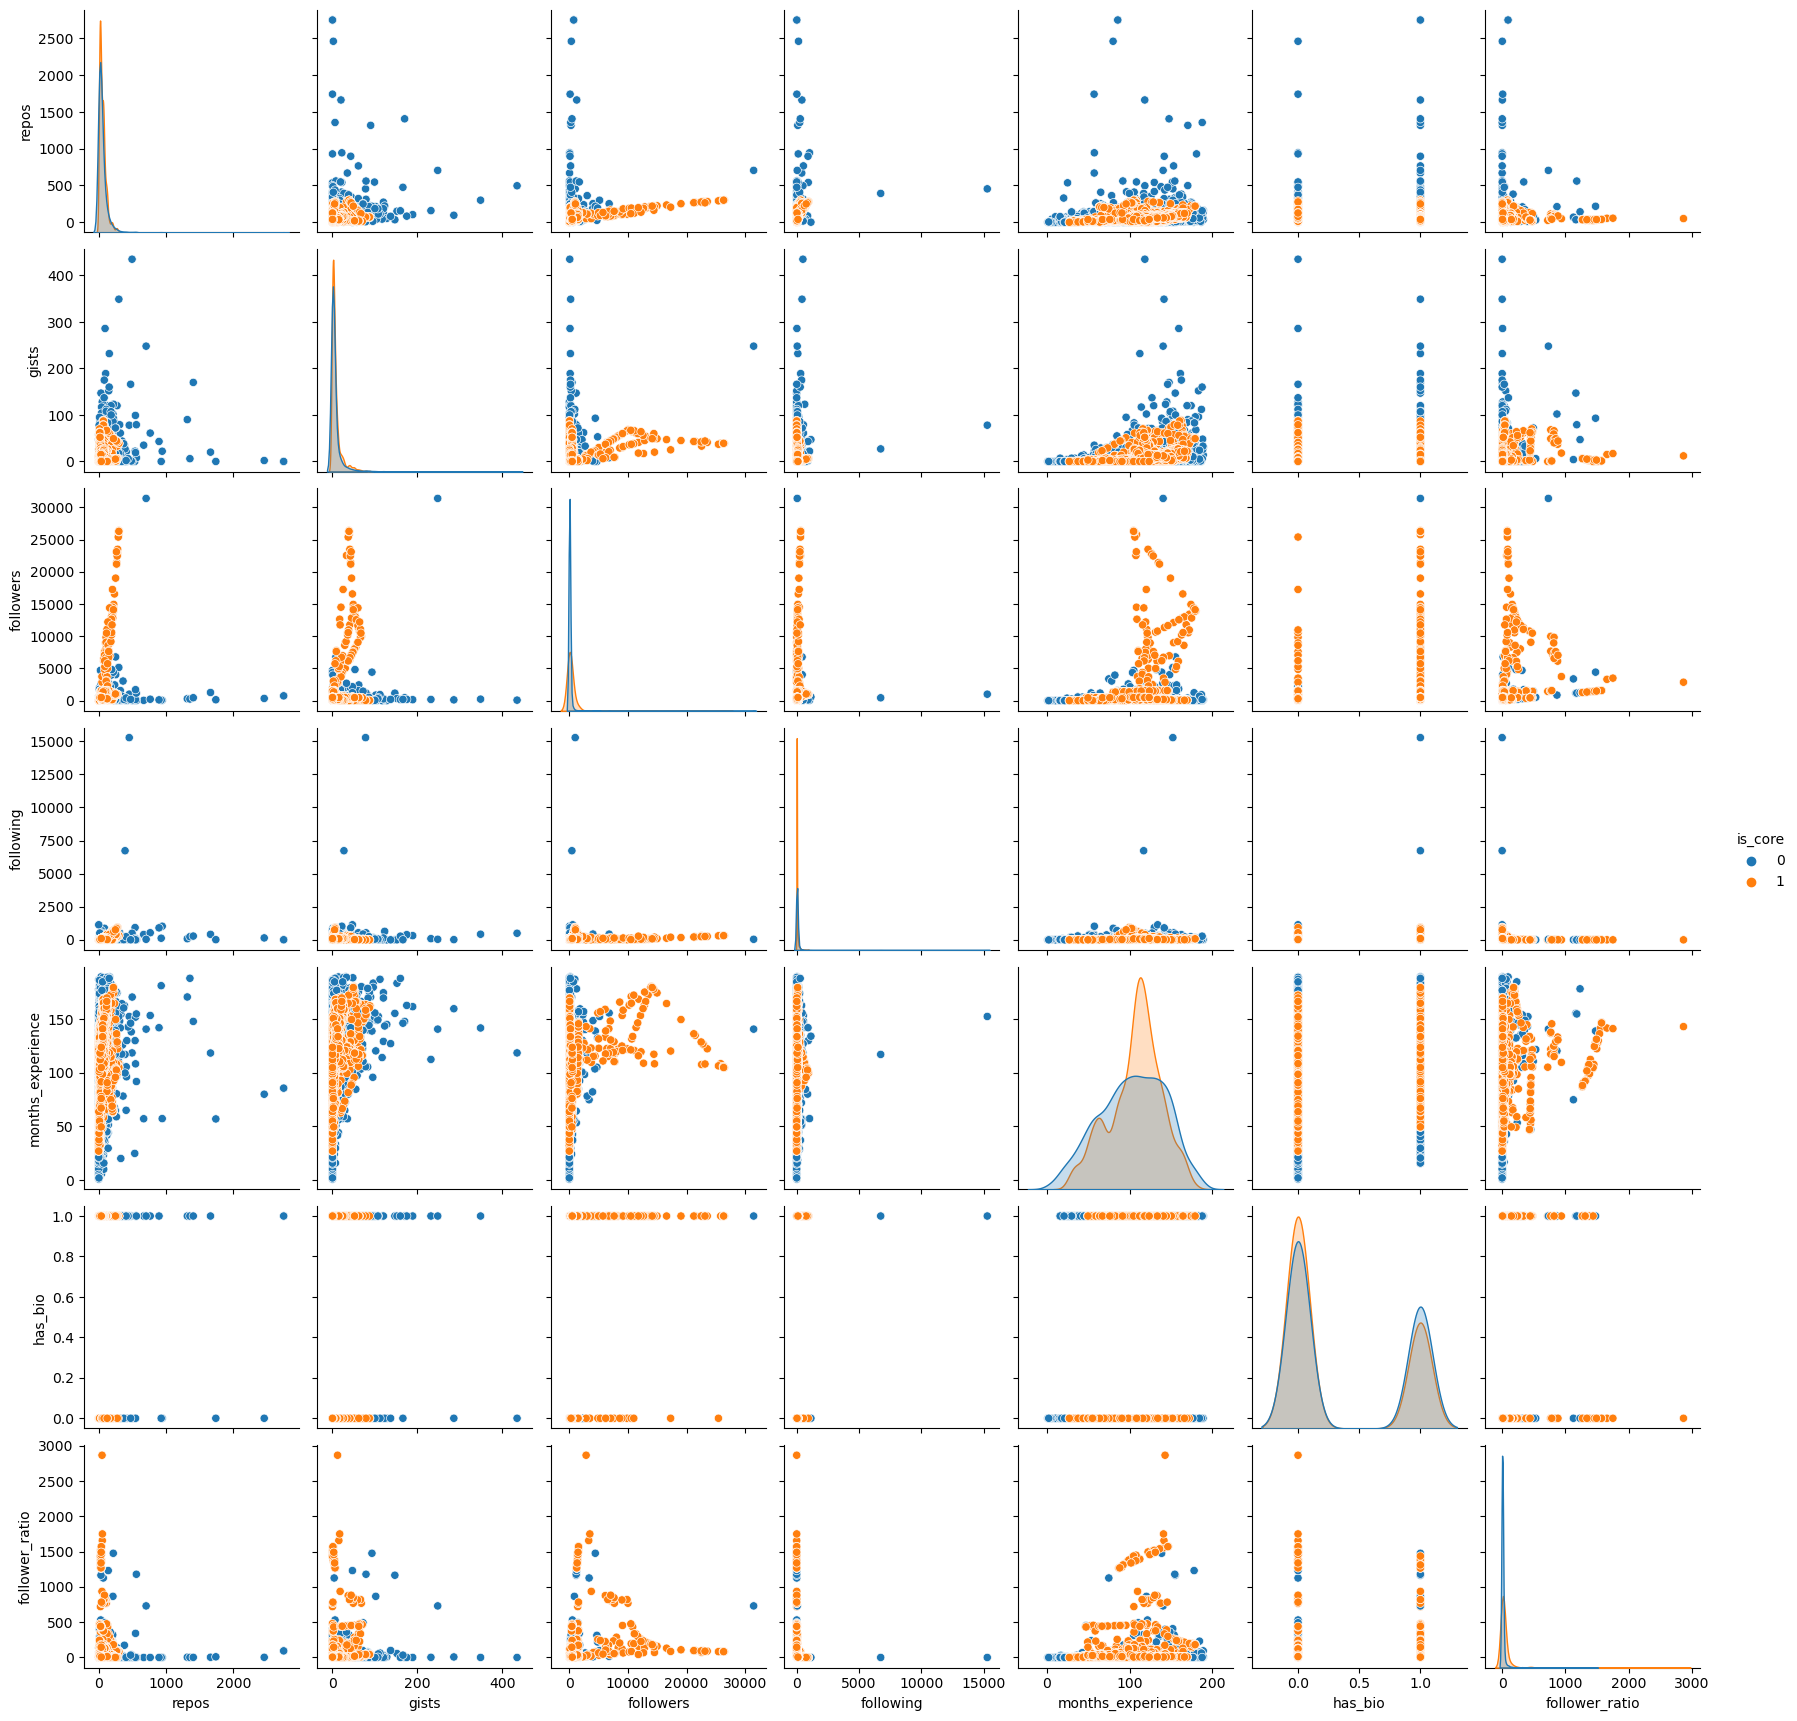

In [10]:
sns.pairplot(c3_train, hue = 'is_core')

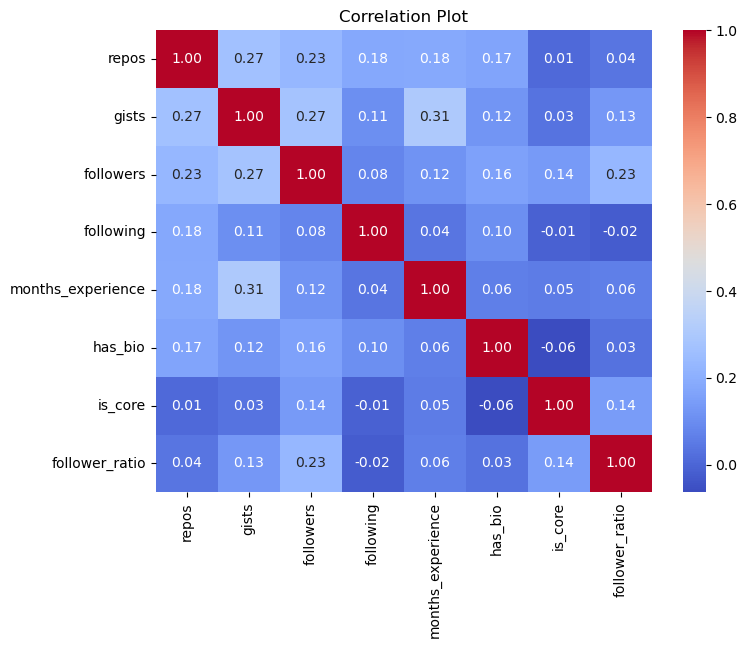

In [11]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c3_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

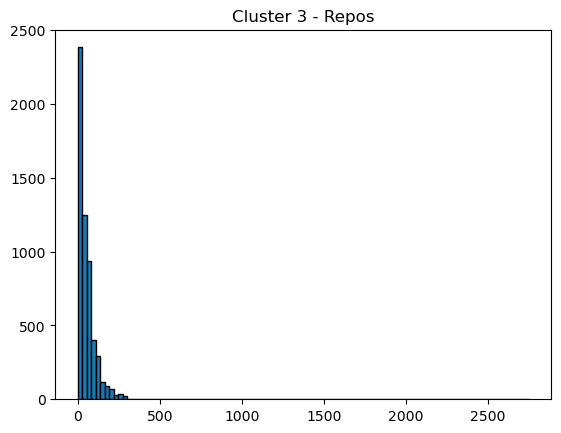

In [12]:
plt.hist(c3_train.repos, bins=100, edgecolor='black')
plt.title('Cluster 3 - Repos')
plt.show()

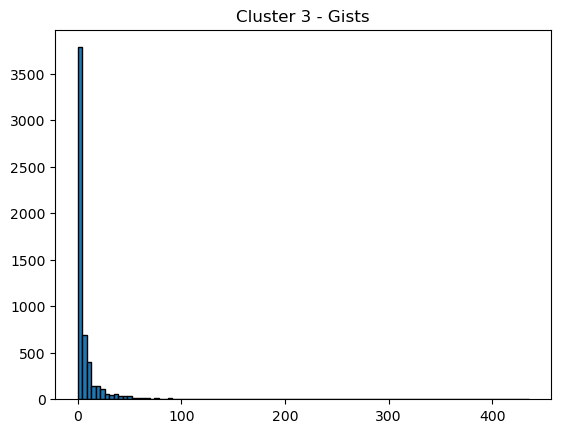

In [13]:
plt.hist(c3_train.gists, bins=100, edgecolor='black')
plt.title('Cluster 3 - Gists')
plt.show()

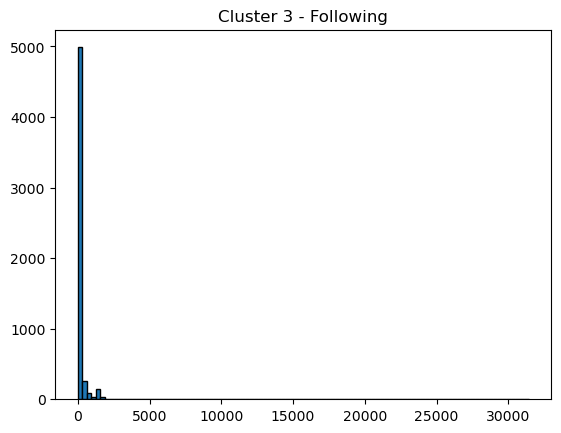

In [14]:
plt.hist(c3_train.followers, bins=100, edgecolor='black')
plt.title('Cluster 3 - Following')
plt.show()

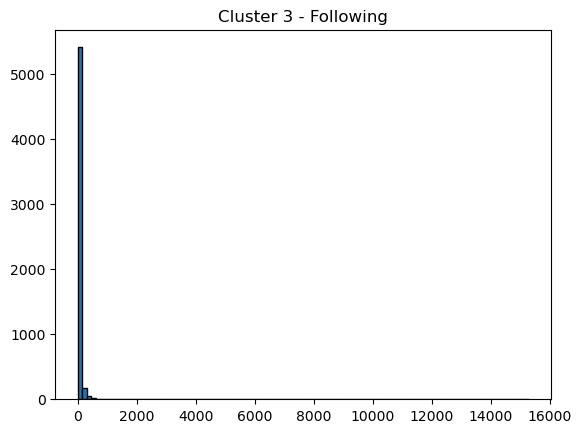

In [15]:
plt.hist(c3_train.following, bins=100, edgecolor='black')
plt.title('Cluster 3 - Following')
plt.show()

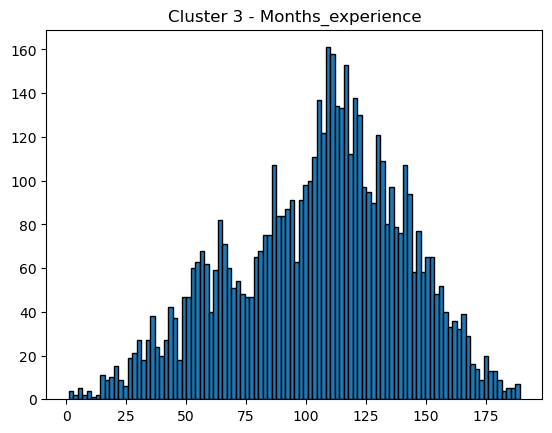

In [16]:
plt.hist(c3_train.months_experience, bins=100, edgecolor='black')
plt.title('Cluster 3 - Months_experience')
plt.show()

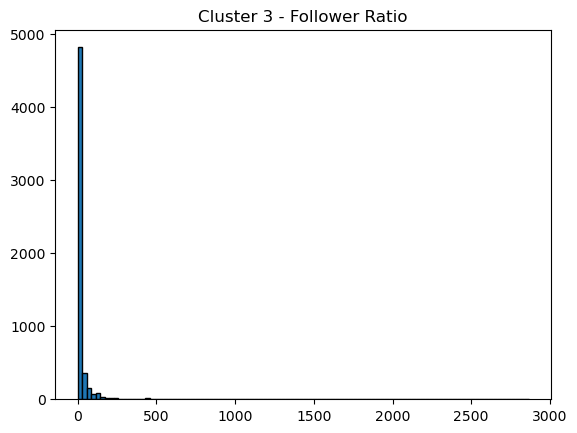

In [17]:
plt.hist(c3_train.follower_ratio, bins=100, edgecolor='black')
plt.title('Cluster 3 - Follower Ratio')
plt.show()

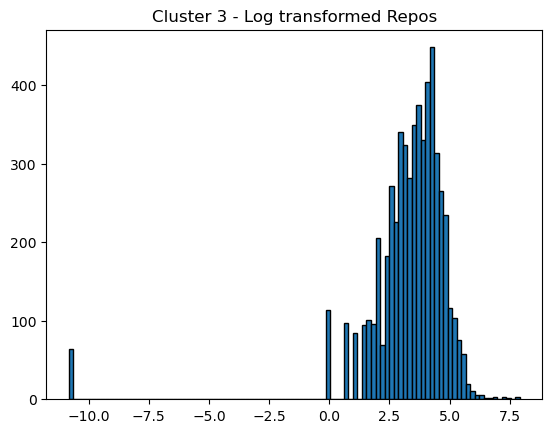

In [18]:
plt.hist(np.log(c3_train.repos+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Repos')
plt.show()

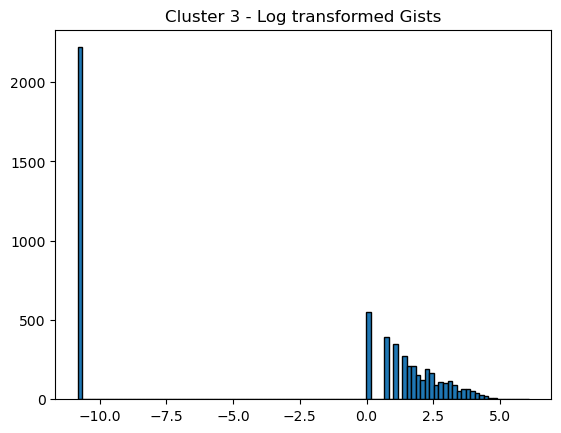

In [19]:
plt.hist(np.log(c3_train.gists+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Gists')
plt.show()

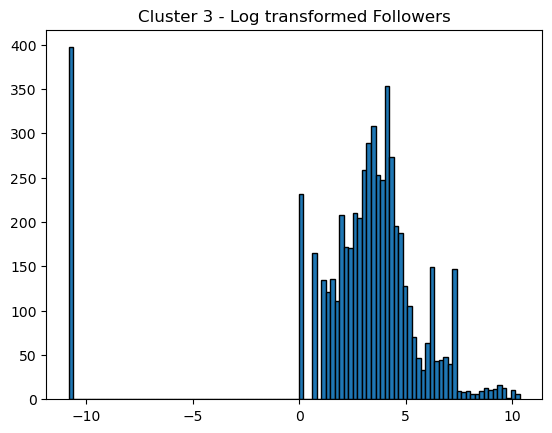

In [20]:
plt.hist(np.log(c3_train.followers+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Followers')
plt.show()

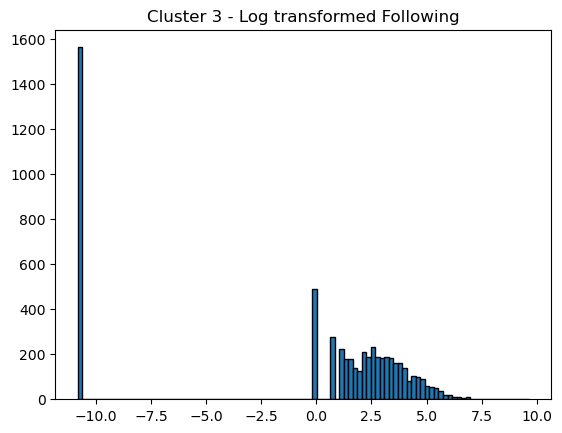

In [21]:
plt.hist(np.log(c3_train.following+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Following')
plt.show()

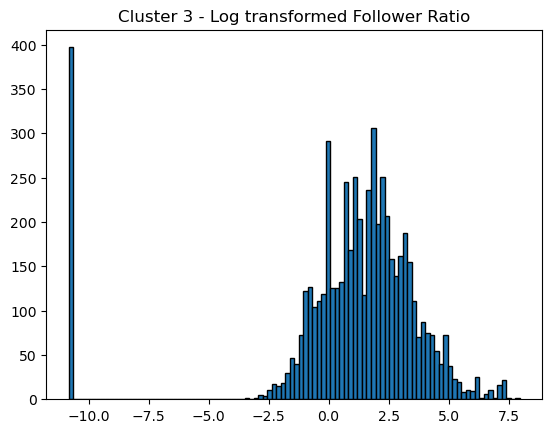

In [22]:
plt.hist(np.log(c3_train.follower_ratio+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 3 - Log transformed Follower Ratio')
plt.show()

In [23]:
c3_train_log = c3_train.copy()
c3_train_log['repos'] = np.log(c3_train_log.repos+2e-5)
c3_train_log['gists'] = np.log(c3_train_log.gists+2e-5)
c3_train_log['followers'] = np.log(c3_train_log.followers+2e-5)
c3_train_log['following'] = np.log(c3_train_log.following+2e-5)
c3_train_log['follower_ratio'] = np.log(c3_train_log.follower_ratio+2e-5)
c3_train_log

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
0,3.332,-10.820,0.000,-10.820,51.040,0,0,0.000
1,3.367,1.099,3.664,2.833,154.540,1,0,0.830
2,3.932,-10.820,5.620,-10.820,144.570,0,0,5.620
3,2.996,-10.820,1.386,2.079,92.560,0,0,-0.693
4,4.025,3.434,4.078,3.135,85.660,1,0,0.942
...,...,...,...,...,...,...,...,...
5668,3.611,0.693,6.111,3.296,67.127,1,1,2.816
5669,3.638,0.693,6.127,3.664,76.072,1,1,2.463
5670,4.836,-10.820,5.684,3.135,90.733,0,1,2.548
5671,2.996,3.951,6.161,3.258,118.309,1,1,2.903


In [24]:
test_df['follower_ratio'] = np.where(test_df['following'] == 0, test_df['followers'], test_df['followers'] / test_df['following'])
test_df

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
532,30,4,53,58,78.520,1,0,0.914
4136,22,21,3,6,115.460,1,0,0.500
1251,150,1,46,69,70.290,1,1,0.667
2206,37,0,9,1,59.000,1,0,9.000
3245,40,0,27,8,93.280,1,0,3.375
...,...,...,...,...,...,...,...,...
3590,233,4,447,363,133.640,1,0,1.231
2896,2,0,0,0,52.930,0,0,0.000
1879,16,0,2,4,46.530,0,0,0.500
2047,67,17,11,6,157.620,0,0,1.833


In [25]:
test_df['repos'] = np.log(test_df.repos+2e-5)
test_df['gists'] = np.log(test_df.gists+2e-5)
test_df['followers'] = np.log(test_df.followers+2e-5)
test_df['following'] = np.log(test_df.following+2e-5)
test_df['follower_ratio'] = np.log(test_df.follower_ratio+2e-5)
test_df

,repos,gists,followers,following,months_experience,has_bio,is_core,follower_ratio
532,3.401,1.386,3.970,4.060,78.520,1,0,-0.090
4136,3.091,3.045,1.099,1.792,115.460,1,0,-0.693
1251,5.011,0.000,3.829,4.234,70.290,1,1,-0.405
2206,3.611,-10.820,2.197,0.000,59.000,1,0,2.197
3245,3.689,-10.820,3.296,2.079,93.280,1,0,1.216
...,...,...,...,...,...,...,...,...
3590,5.451,1.386,6.103,5.894,133.640,1,0,0.208
2896,0.693,-10.820,-10.820,-10.820,52.930,0,0,-10.820
1879,2.773,-10.820,0.693,1.386,46.530,0,0,-0.693
2047,4.205,2.833,2.398,1.792,157.620,0,0,0.606


In [26]:
scaler = StandardScaler()
X_std = c3_train_log.drop(columns=['has_bio', 'is_core'])
x2 = c3_train_log[['has_bio', 'is_core']]
X_std = scaler.fit_transform(X_std)
train = pd.DataFrame(X_std, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'follower_ratio'])
train = pd.concat([train, x2], axis = 1)
train

,repos,gists,followers,following,months_experience,follower_ratio,has_bio,is_core
0,0.028,-1.233,-0.632,-1.581,-1.510,-0.219,0,0
1,0.047,0.692,0.261,0.657,1.390,0.010,1,0
2,0.341,-1.233,0.738,-1.581,1.110,1.334,0,0
3,-0.147,-1.233,-0.294,0.533,-0.347,-0.411,0,0
4,0.390,1.069,0.362,0.706,-0.540,0.041,1,0
...,...,...,...,...,...,...,...,...
5668,0.174,0.627,0.857,0.733,-1.059,0.559,1,1
5669,0.187,0.627,0.861,0.793,-0.809,0.461,1,1
5670,0.812,-1.233,0.753,0.706,-0.398,0.485,0,1
5671,-0.147,1.153,0.869,0.726,0.375,0.583,1,1


In [27]:
X_std = test_df.drop(columns=['has_bio', 'is_core'])
x2 = test_df[['has_bio', 'is_core']]
X_std = scaler.transform(X_std)
test = pd.DataFrame(X_std, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'follower_ratio'])
test = test.reset_index(drop=True)
x2 = x2.reset_index(drop=True)
test = pd.concat([test, x2], axis = 1)
test

,repos,gists,followers,following,months_experience,follower_ratio,has_bio,is_core
0,0.064,0.739,0.336,0.858,-0.740,-0.244,1,0
1,-0.098,1.006,-0.364,0.486,0.295,-0.411,1,0
2,0.903,0.515,0.301,0.886,-0.971,-0.331,1,1
3,0.174,-1.233,-0.096,0.192,-1.287,0.388,1,0
4,0.214,-1.233,0.171,0.533,-0.327,0.117,1,0
...,...,...,...,...,...,...,...,...
725,1.133,0.739,0.855,1.158,0.804,-0.162,1,0
726,-1.348,-1.233,-3.268,-1.581,-1.457,-3.208,0,0
727,-0.264,-1.233,-0.463,0.420,-1.636,-0.411,0,0
728,0.483,0.972,-0.047,0.486,1.476,-0.052,0,0


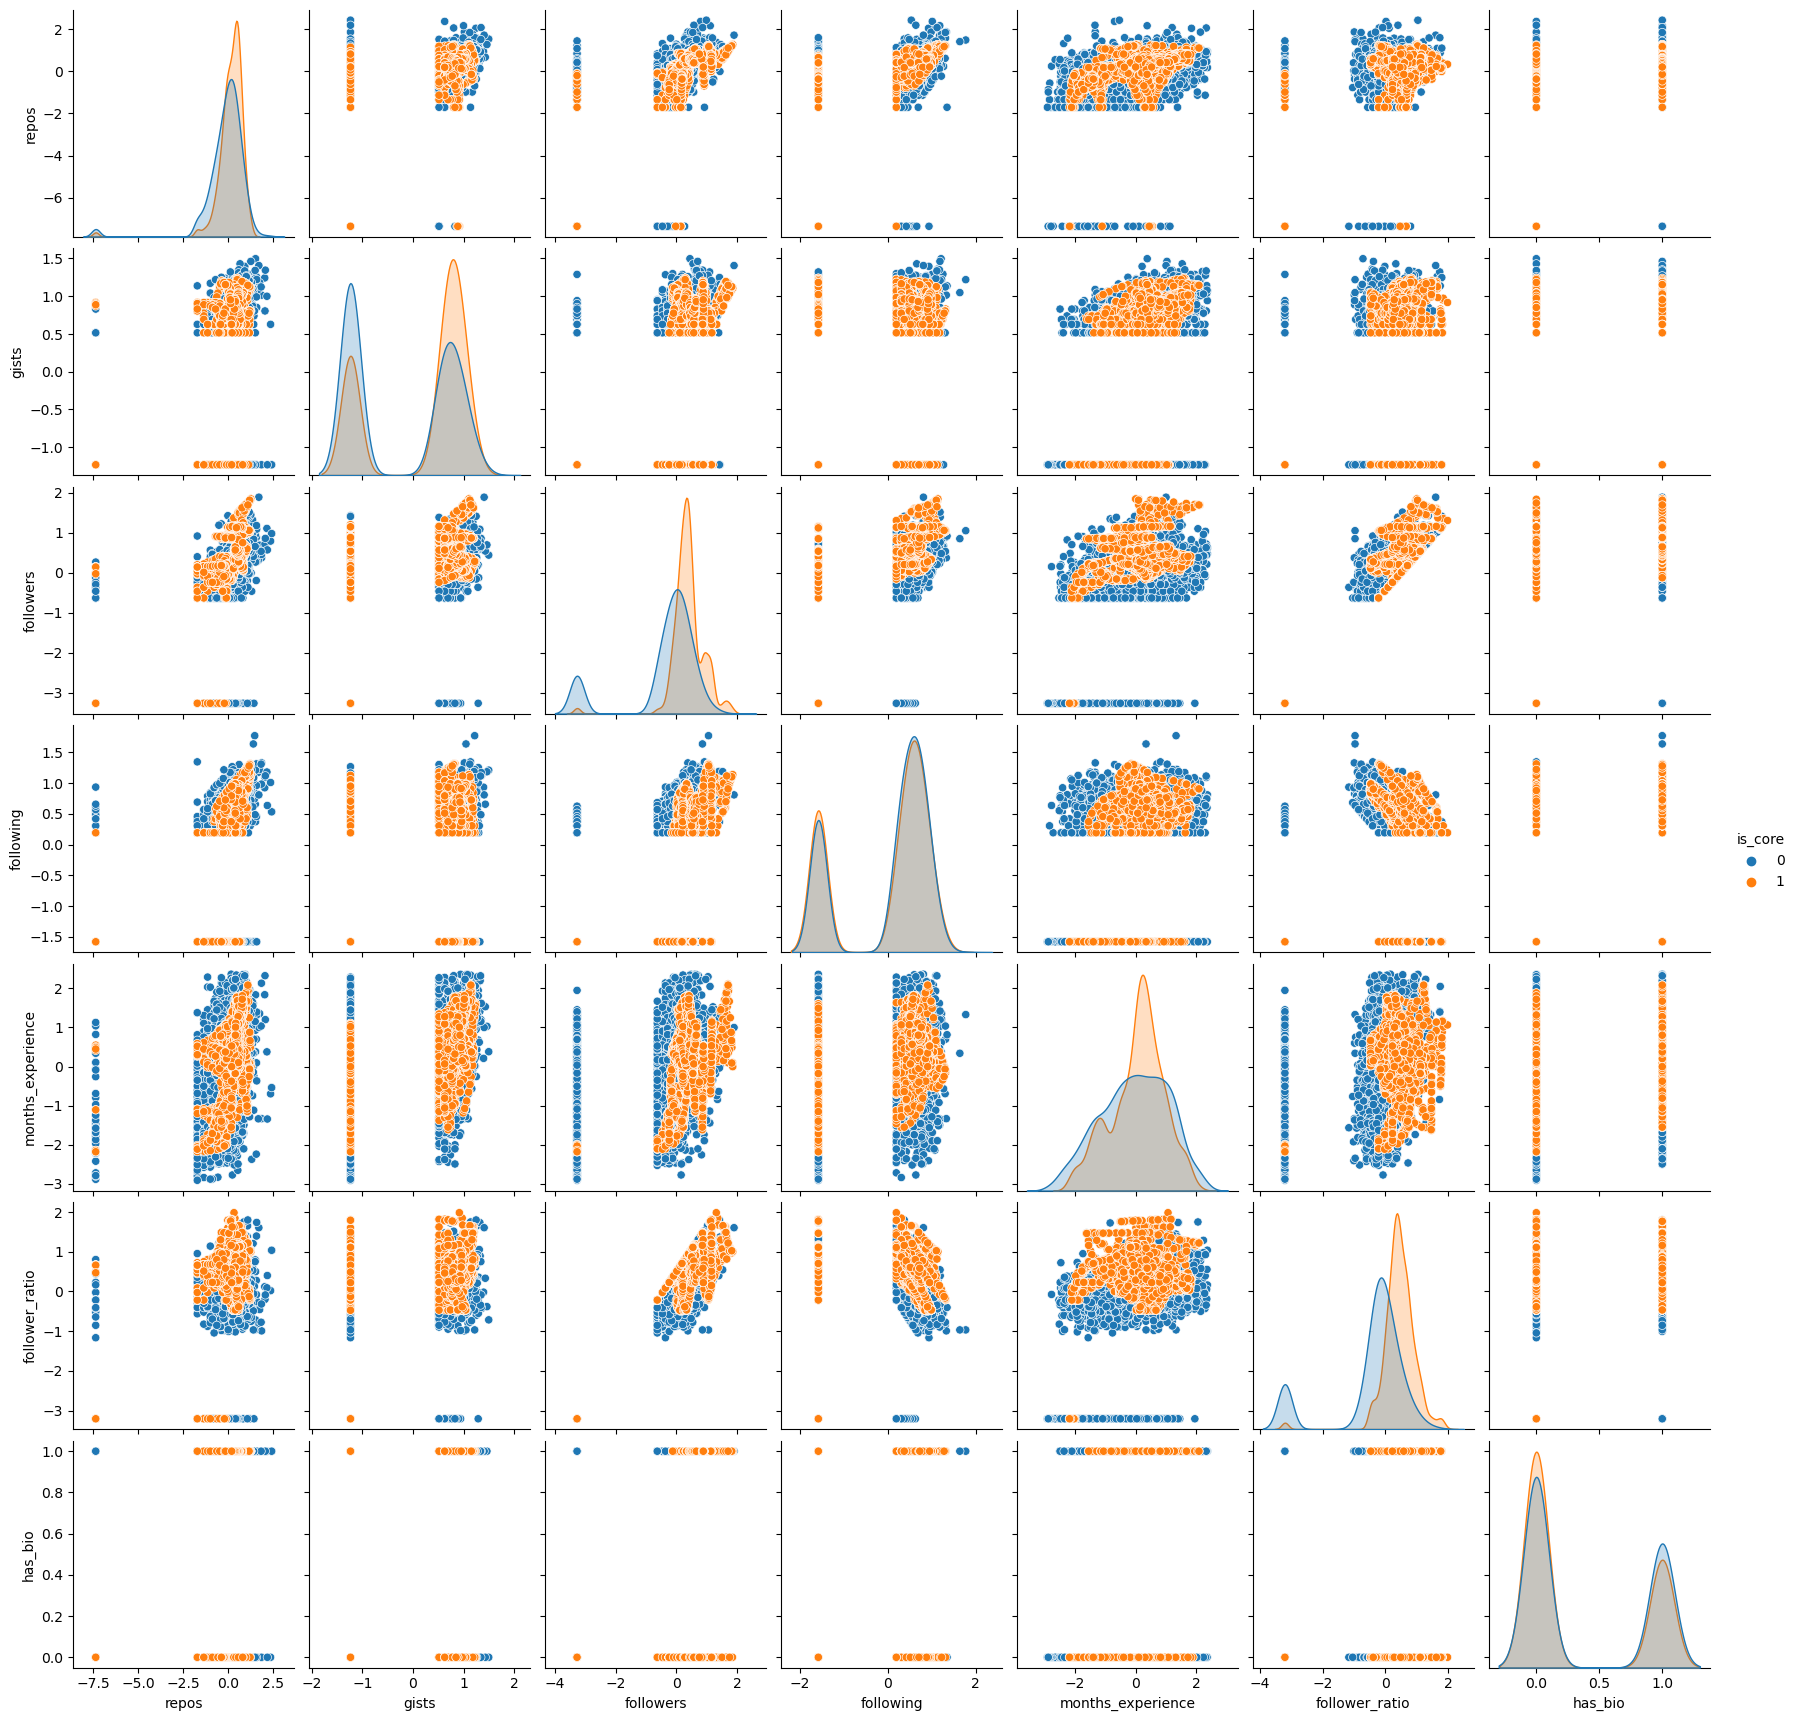

In [28]:
sns.pairplot(train, hue = 'is_core')

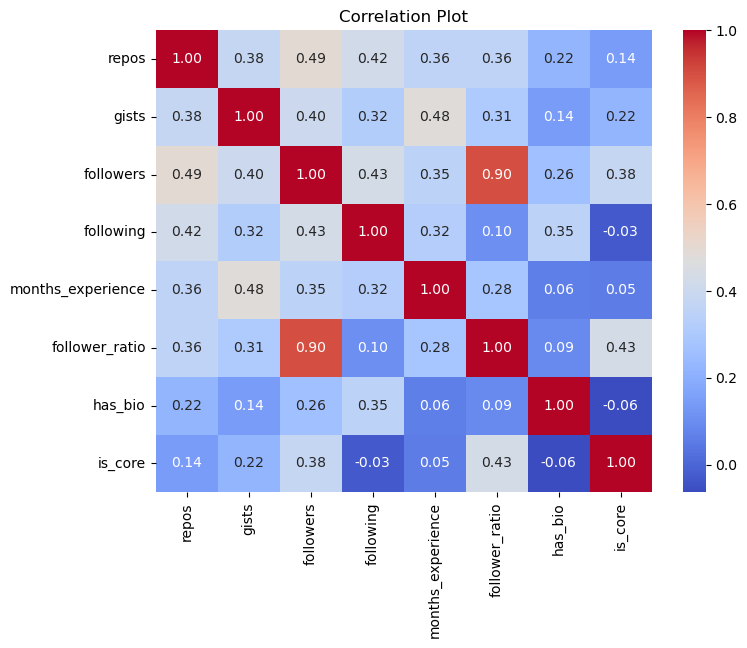

In [29]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

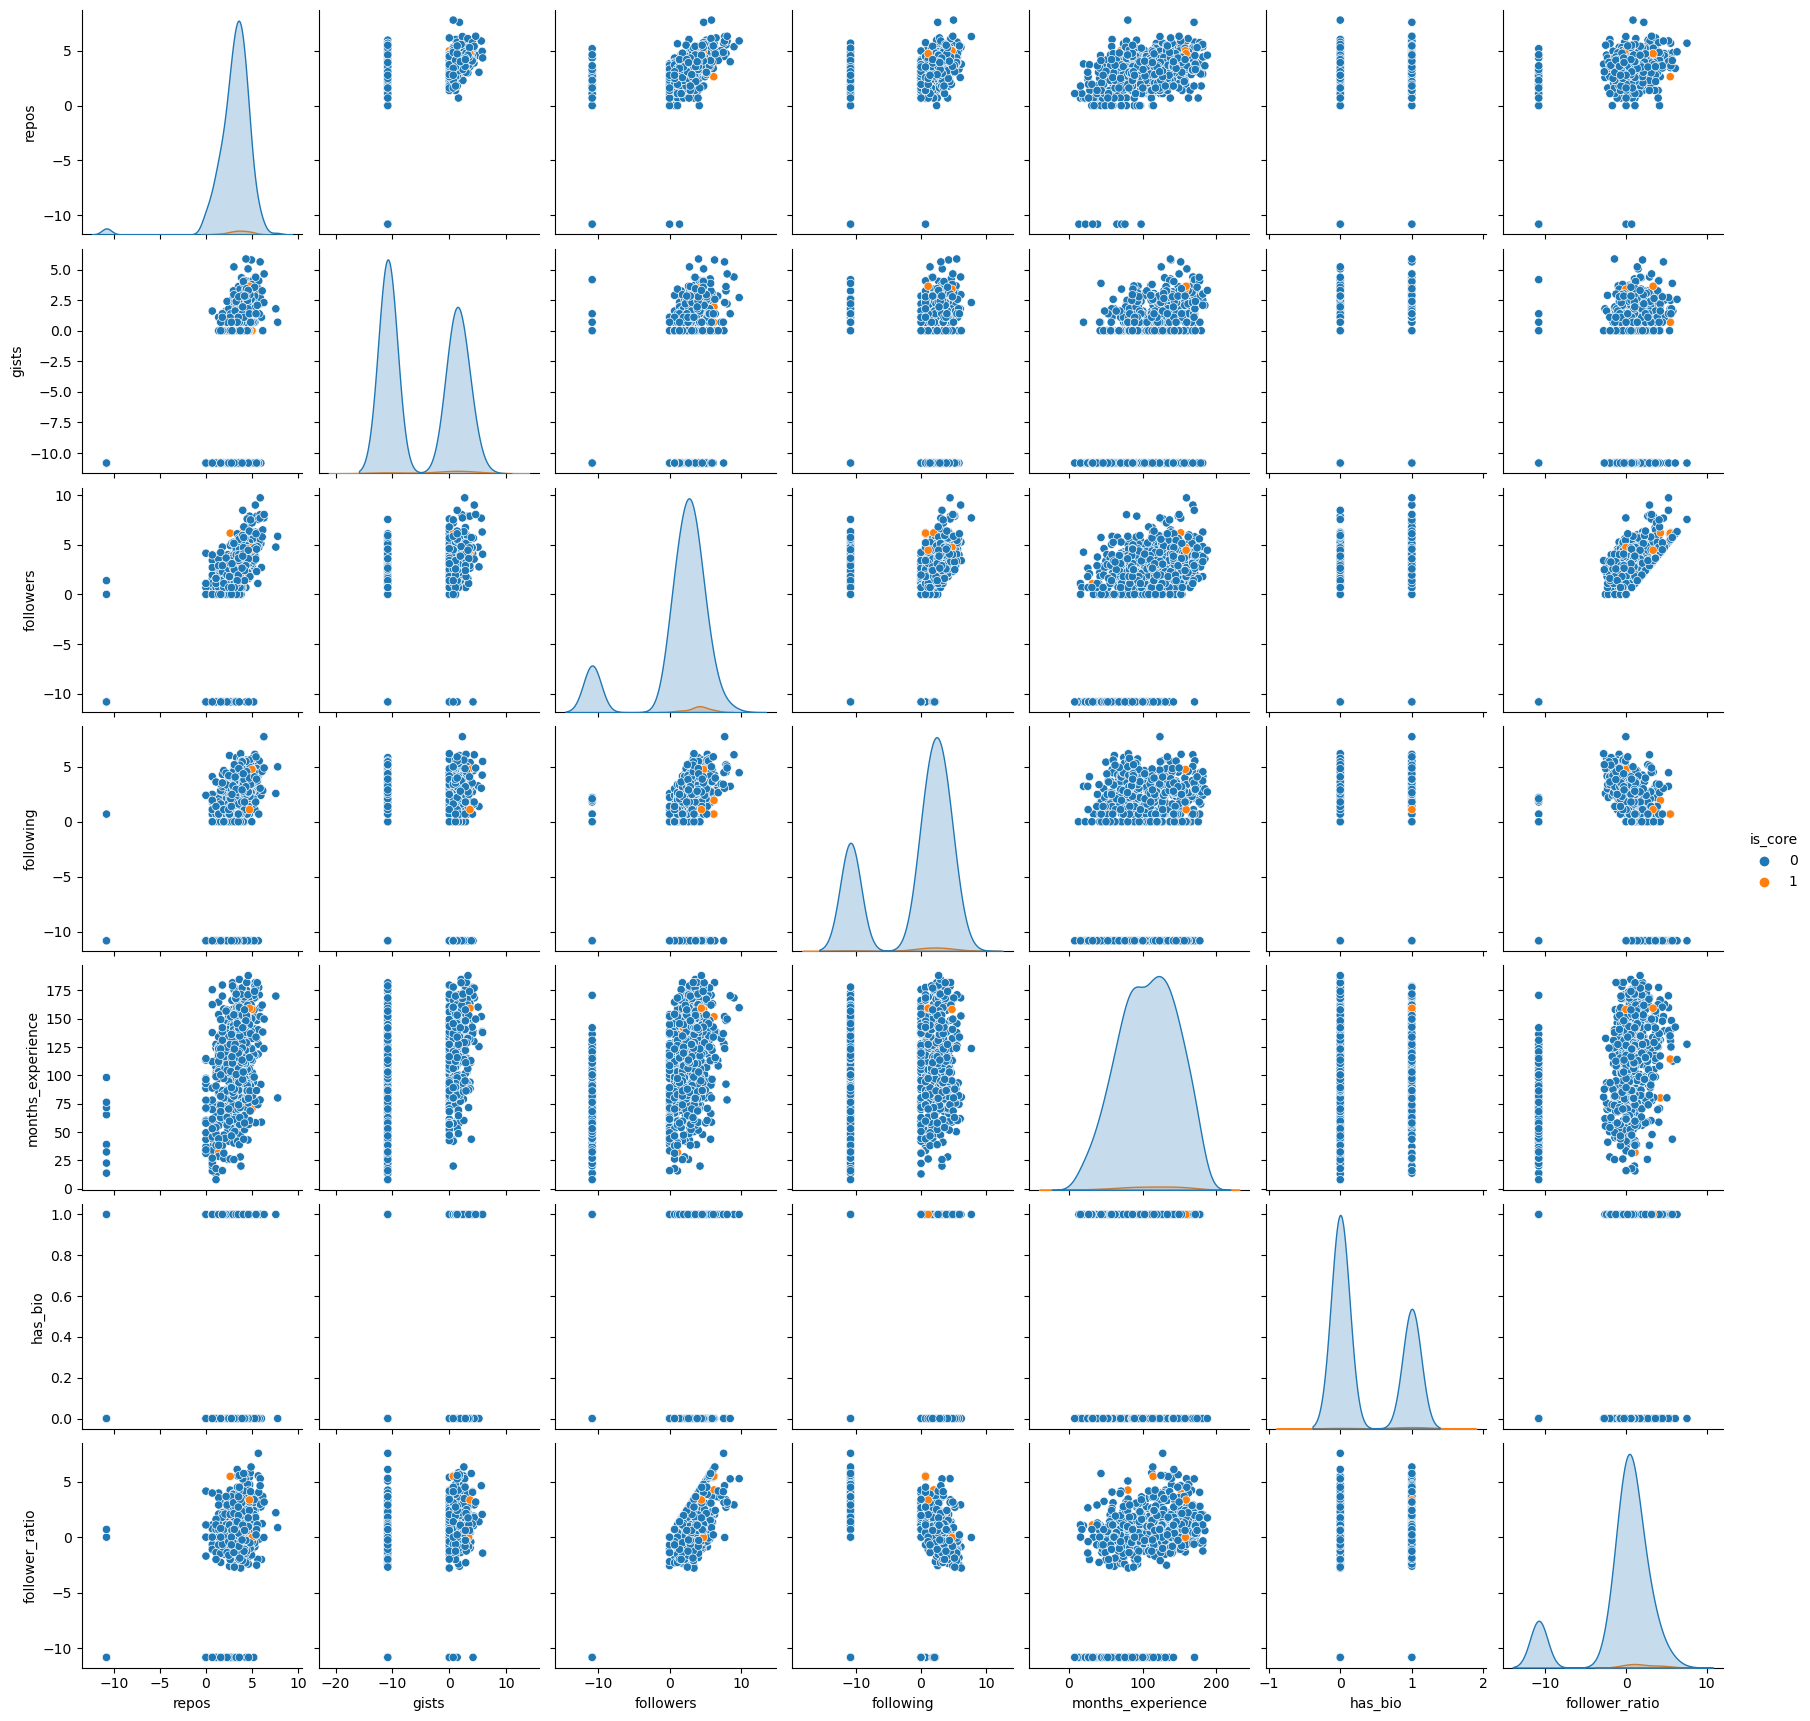

In [30]:
sns.pairplot(test_df, hue = 'is_core')

In [31]:
X = train.drop('is_core', axis=1)
y = train['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0323
gists: 0.0564
followers: 0.1505
following: 0.0135
months_experience: 0.0571
follower_ratio: 0.2358
has_bio: 0.0060


In [32]:
train['has_bio'] = pd.Categorical(train['has_bio'])
train['has_bio'] = pd.Categorical(train['has_bio'])

test['is_core'] = pd.Categorical(test['is_core'])
test['is_core'] = pd.Categorical(test['is_core'])

X_train = train.drop(columns = "is_core")
X_test = test.drop(columns = 'is_core')

y_train = train['is_core']
y_test = test['is_core']

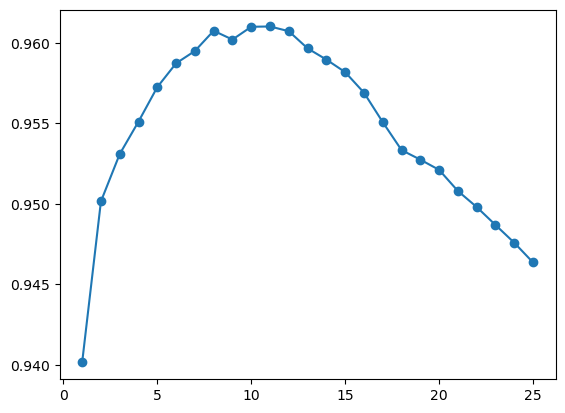

In [33]:
# Create a KNN classifier
k_vals = list(range(1, 26))
scores = []

for k in k_vals:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)  # You can adjust the number of neighbors (n_neighbors) as needed

    # Perform 10-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=kf, scoring = 'roc_auc')
    
    scores.append(np.mean(cv_scores))
    
plt.plot(k_vals, scores, marker='o', linestyle='-')
plt.show()

In [34]:
max_k = scores.index(max(scores))+1
knn_classifier = KNeighborsClassifier(n_neighbors=max_k)
knn_classifier.fit(X_train, y_train)


y_pred = knn_classifier.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[558 160]
 [  7   5]]

Test Set Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       718
           1       0.03      0.42      0.06        12

    accuracy                           0.77       730
   macro avg       0.51      0.60      0.46       730
weighted avg       0.97      0.77      0.86       730



In [35]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_samples': [0.5, 0.6, 0.7]
}


# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 10-fold cross-validation
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs=-1)

t1 = time.time()
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", rf_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(rf_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
rf_best_model = rf_grid_search.best_estimator_
y_pred = rf_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Search completed in 1.03 Minutes

Best Hyperparameters: {'max_depth': 10, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.95
Confusion Matrix:
[[612 106]
 [  7   5]]

Test Set Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       718
           1       0.05      0.42      0.08        12

    accuracy                           0.85       730
   macro avg       0.52      0.63      0.50       730
weighted avg       0.97      0.85      0.90       730



In [36]:
y_pred = rf_best_model.predict(X_train)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_train, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[2591  255]
 [  10 2817]]

Test Set Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2846
           1       0.92      1.00      0.96      2827

    accuracy                           0.95      5673
   macro avg       0.96      0.95      0.95      5673
weighted avg       0.96      0.95      0.95      5673



In [37]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [3, 5, 10, 25],
    'min_samples_leaf': [2, 3, 5, 10]
}


# Initialize the DT Classifier
clf = tree.DecisionTreeClassifier(random_state=42, criterion = 'entropy')

# Initialize GridSearchCV with 10-fold cross-validation
dt_grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)

t1 = time.time()
# Fit the grid search to the data
dt_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", dt_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(dt_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
dt_best_model = dt_grid_search.best_estimator_
y_pred = dt_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Search completed in 0.01 Minutes

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 3}
Best Cross-Validation Accuracy: 0.89
Confusion Matrix:
[[603 115]
 [  8   4]]

Test Set Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       718
           1       0.03      0.33      0.06        12

    accuracy                           0.83       730
   macro avg       0.51      0.59      0.48       730
weighted avg       0.97      0.83      0.89       730



In [38]:
y_pred = dt_best_model.predict(X_train)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_train, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[2469  377]
 [ 130 2697]]

Test Set Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      2846
           1       0.88      0.95      0.91      2827

    accuracy                           0.91      5673
   macro avg       0.91      0.91      0.91      5673
weighted avg       0.91      0.91      0.91      5673



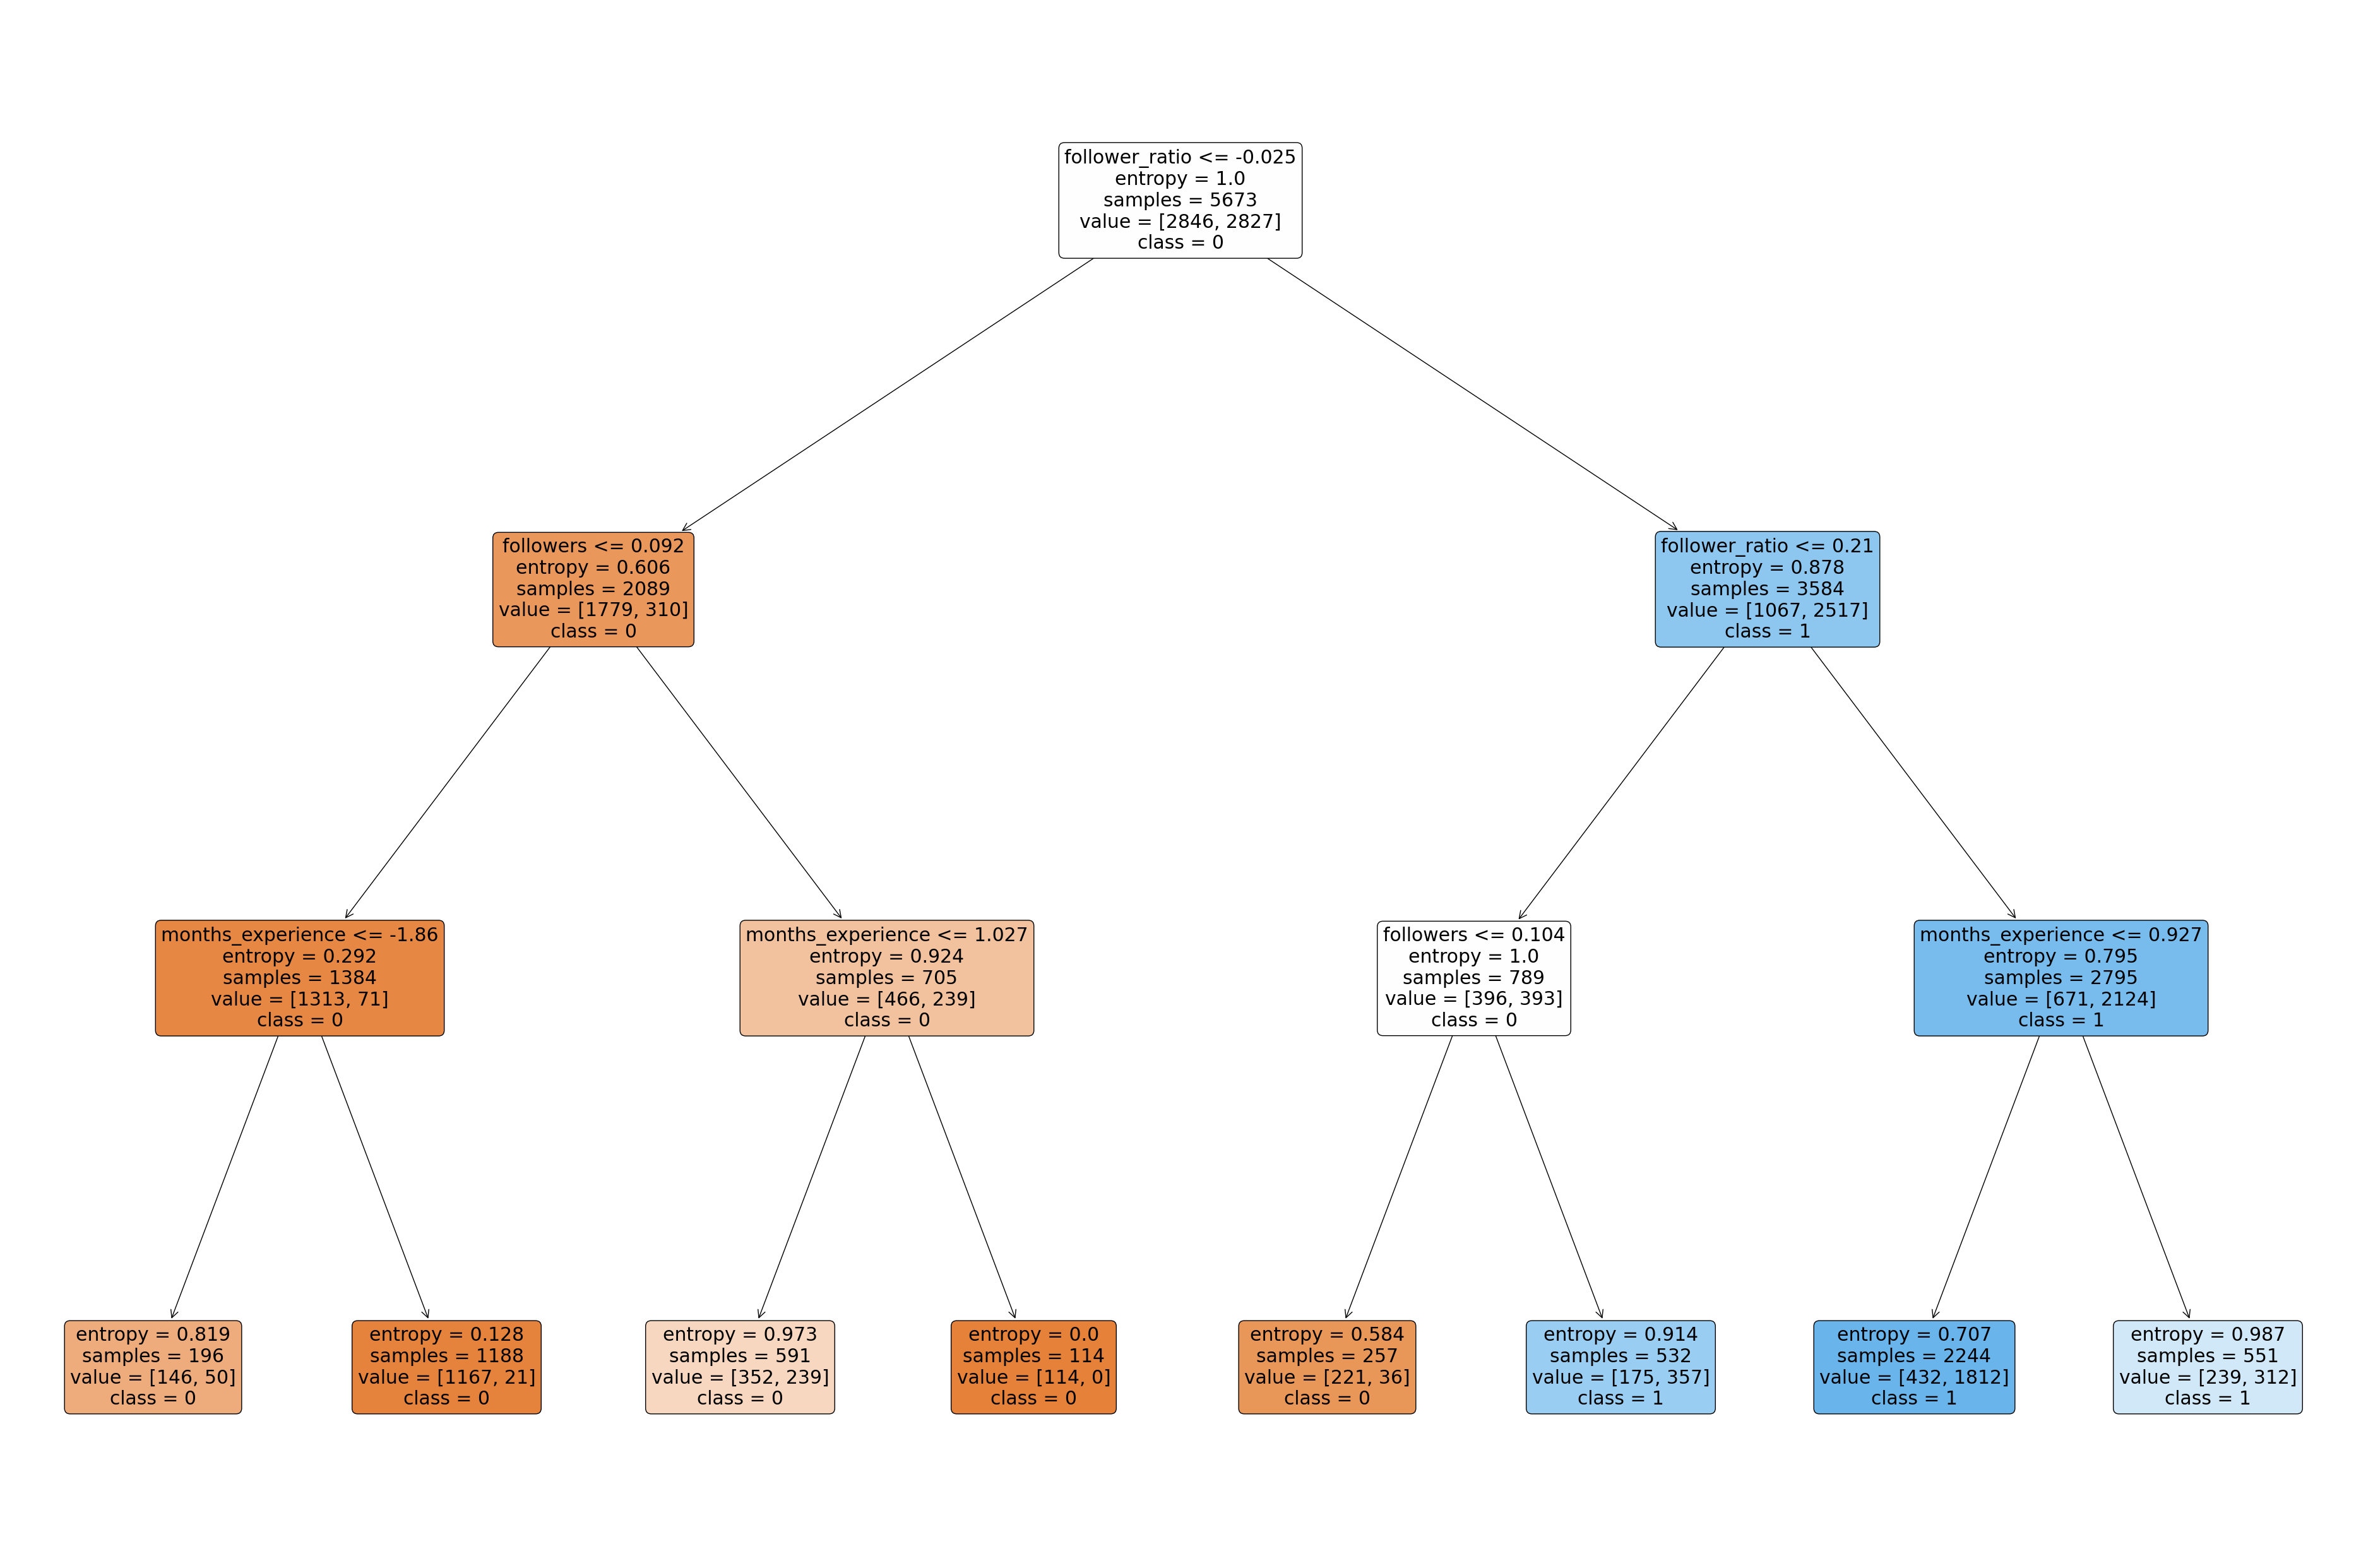

In [39]:
clf = tree.DecisionTreeClassifier(max_depth = 3, criterion='entropy')
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(48, 32))
tree.plot_tree(clf, filled = True, rounded = True, feature_names = X_train.columns, class_names = y_train.unique().astype(str).tolist())
plt.show()

In [40]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


# Initialize the Random Forest Classifier
xgboost = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with 10-fold cross-validation
xg_grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)

t1 = time.time()
# Fit the grid search to the data
xg_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

# Print the best hyperparameters
print("Best Hyperparameters:", xg_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(xg_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
xg_best_model = xg_grid_search.best_estimator_
y_pred = xg_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Search completed in 3.36 Minutes

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.97
Confusion Matrix:
[[674  44]
 [ 10   2]]

Test Set Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       718
           1       0.04      0.17      0.07        12

    accuracy                           0.93       730
   macro avg       0.51      0.55      0.52       730
weighted avg       0.97      0.93      0.95       730



In [41]:
# Define the logistic regression model
logistic_regression = LogisticRegression(solver = 'saga', random_state = 42)

# Define the hyperparameter grid to search through
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],  # Regularization type
    'C': [0.001, 0.01, 0.1, 1, 10],                  # Inverse of regularization strength              # Algorithm to use in the optimization problem
    'l1_ratio': [0.1, 0.5, 0.9],                    # Elastic Net mixing parameter (used when penalty='elasticnet')
}

# Initialize GridSearchCV
log_grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=10, scoring='roc_auc', verbose = 1, n_jobs = -1)
t1 = time.time()
# Fit the grid search to the data
log_grid_search.fit(X_train, y_train)

print("Search completed in", str(round((time.time() - t1) / 60, 2)), "Minutes\n")

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Search completed in 0.01 Minutes



C:\Users\Ethan Smith\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [42]:
# Print the best hyperparameters
print("Best Hyperparameters:", log_grid_search.best_params_)

# Print the best cross-validation score
print("Best Cross-Validation Accuracy: {:.2f}".format(log_grid_search.best_score_))

# Evaluate the model on the test set with the best parameters
log_best_model = log_grid_search.best_estimator_
y_pred = log_best_model.predict(X_test)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.2f}")

# Print a classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'l1'}
Best Cross-Validation Accuracy: 0.84
Confusion Matrix:
[[537 181]
 [  6   6]]

Test Set Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       718
           1       0.03      0.50      0.06        12

    accuracy                           0.74       730
   macro avg       0.51      0.62      0.46       730
weighted avg       0.97      0.74      0.84       730

